<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11250 entries, 2024-06-10 09:15:00 to 2024-07-19 15:29:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    11250 non-null  float64
 1   High    11250 non-null  float64
 2   Low     11250 non-null  float64
 3   Close   11250 non-null  float64
 4   Volume  11250 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 527.3 KB
None
               Open          High           Low         Close        Volume
count  11250.000000  11250.000000  11250.000000  11250.000000  11250.000000
mean   22984.492674  22986.982078  22982.004644  22984.501404   5456.308356
std      102.218371    102.219654    102.233948    102.222775   2600.632125
min    22758.900000  22760.640000  22755.730000  22756.950000   1000.000000
25%    22910.522500  22913.190000  22907.482500  22910.852500   3187.000000
50%    22998.225000  23000.865000  22995.805000  22998.280000   5412.000000
75%    23

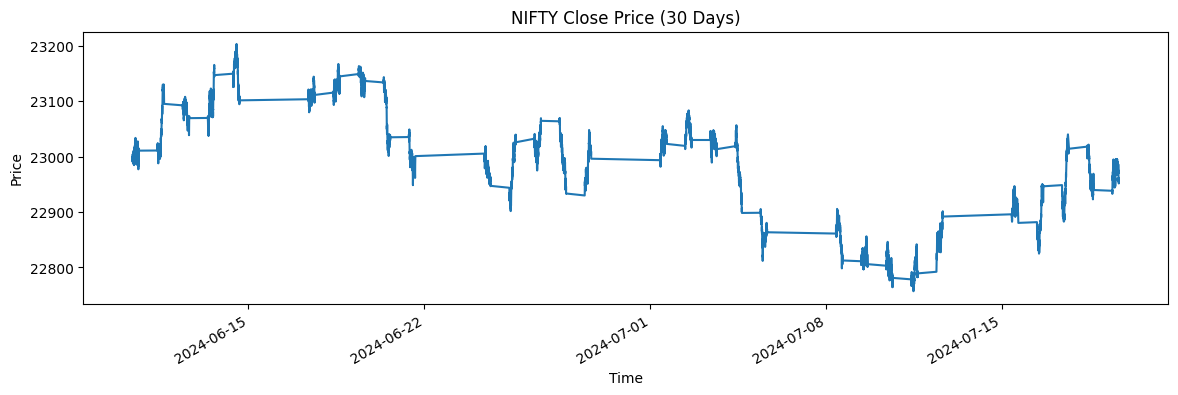

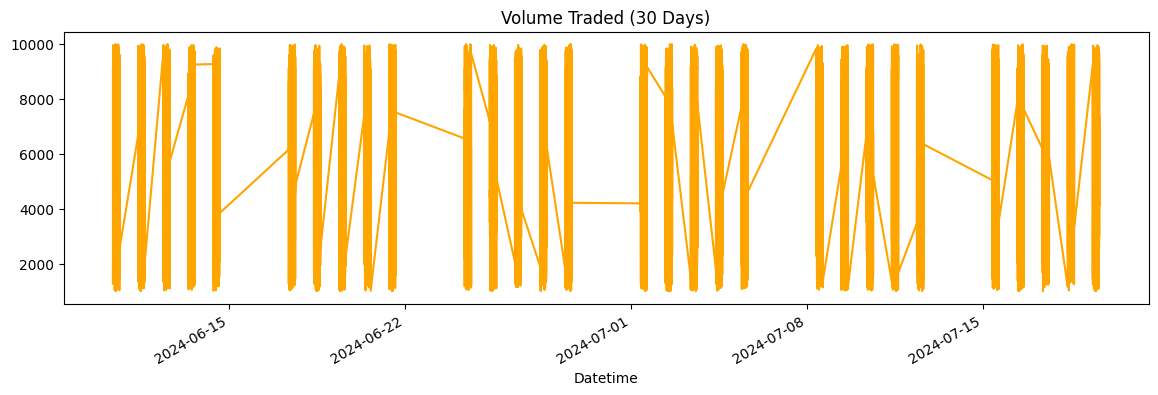

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("nifty_30days.csv")

# Convert to datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set datetime as index (optional)
df.set_index('Datetime', inplace=True)

# Display basic info
print(df.info())
print(df.describe())

# Plot Close price over time
df['Close'].plot(figsize=(14, 4), title="NIFTY Close Price (30 Days)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

# Volume spikes
df['Volume'].plot(figsize=(14, 4), title="Volume Traded (30 Days)", color="orange")
plt.show()


In [2]:
# Extract only date (for grouping)
df['Date'] = df.index.date

# Compute daily closing price
daily_close = df.groupby('Date')['Close'].last()

# Create label: next day's price movement
labels = (daily_close.shift(-1) > daily_close).astype(int)
labels = labels.dropna()


In [3]:
labels

Date
2024-06-10    1
2024-06-11    0
2024-06-12    1
2024-06-13    0
2024-06-14    1
2024-06-17    1
2024-06-18    0
2024-06-19    0
2024-06-20    0
2024-06-21    0
2024-06-24    1
2024-06-25    1
2024-06-26    0
2024-06-27    1
2024-06-28    1
2024-07-01    1
2024-07-02    0
2024-07-03    0
2024-07-04    0
2024-07-05    0
2024-07-08    0
2024-07-09    0
2024-07-10    1
2024-07-11    1
2024-07-12    0
2024-07-15    1
2024-07-16    1
2024-07-17    0
2024-07-18    1
2024-07-19    0
Name: Close, dtype: int64

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X_segments = []
y_labels = []

for date, group in df.groupby('Date'):
    if date not in labels:
        continue

    if len(group) < 50:  # Skip incomplete days
        continue

    # Extract features
    features = group[['Open', 'High', 'Low', 'Close', 'Volume']].values

    # Normalize per day
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    X_segments.append(features_scaled)
    y_labels.append(labels[date])


In [5]:
df.head()

,Open,High,Low,Close,Volume,Date
Datetime,,,,,,
2024-06-10 09:15:00,22999.78,23000.24,22998.40,22998.93,9109,2024-06-10
2024-06-10 09:16:00,22997.94,22998.94,22996.33,22996.29,1269,2024-06-10
2024-06-10 09:17:00,23000.23,23001.69,22995.90,22999.14,1930,2024-06-10
2024-06-10 09:18:00,22996.84,22998.17,22992.08,22996.74,7205,2024-06-10
2024-06-10 09:19:00,22992.82,22994.13,22992.68,22991.75,6075,2024-06-10


In [6]:
from sklearn.utils import resample

X = np.array(X_segments)
y = np.array(y_labels)

# Separate classes
X_up = X[y == 1]
X_down = X[y == 0]

# Balance the classes by resampling
min_len = min(len(X_up), len(X_down))
X_up_bal = resample(X_up, replace=False, n_samples=min_len, random_state=42)
X_down_bal = resample(X_down, replace=False, n_samples=min_len, random_state=42)

# Combine and shuffle
X_balanced = np.concatenate([X_up_bal, X_down_bal])
y_balanced = np.array([1] * min_len + [0] * min_len)

# Shuffle
from sklearn.utils import shuffle
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

print("✅ Balanced dataset shape:", X_balanced.shape, y_balanced.shape)


✅ Balanced dataset shape: (28, 375, 5) (28,)


In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Load data
df = pd.read_csv("nifty_30days.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Extract date
df['Date'] = df.index.date

# Columns to normalize
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Container for normalized sequences
normalized_days = []

# Normalize each day's data
for date, group in df.groupby('Date'):
    if len(group) < 50:  # Skip incomplete days
        continue

    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(group[features])

    normalized_df = pd.DataFrame(scaled_values, columns=features, index=group.index)
    normalized_df['Date'] = date
    normalized_days.append(normalized_df)

# Combine all normalized data
normalized_df_all = pd.concat(normalized_days)

# Reset index if needed
normalized_df_all.reset_index(inplace=True)

print("✅ Normalized shape:", normalized_df_all.shape)
print(normalized_df_all.head())


✅ Normalized shape: (11250, 7)
             Datetime      Open      High       Low     Close    Volume  \
0 2024-06-10 09:15:00  0.426117  0.411540  0.426775  0.387643  0.902149   
1 2024-06-10 09:16:00  0.393865  0.389924  0.391607  0.341041  0.029389   
2 2024-06-10 09:17:00  0.434005  0.435650  0.384302  0.391350  0.102972   
3 2024-06-10 09:18:00  0.374584  0.377120  0.319402  0.348985  0.690193   
4 2024-06-10 09:19:00  0.304119  0.309943  0.329596  0.260900  0.564399   

         Date  
0  2024-06-10  
1  2024-06-10  
2  2024-06-10  
3  2024-06-10  
4  2024-06-10  


In [8]:
# Get the last Close price of each day
daily_close = df.groupby('Date')['Close'].last()

# Compare with next day's close
labels = (daily_close.shift(-1) > daily_close).astype(int)
labels.name = "Label"
labels = labels.dropna()  # Drop the last NaN

# Merge labels into normalized_df_all
normalized_df_all['Label'] = normalized_df_all['Date'].map(labels)

# Drop rows with no label (e.g., last day)
normalized_df_all = normalized_df_all.dropna(subset=['Label'])
normalized_df_all['Label'] = normalized_df_all['Label'].astype(int)

print("✅ Labels added!")
print(normalized_df_all[['Date', 'Close', 'Label']].drop_duplicates().head())


✅ Labels added!
         Date     Close  Label
0  2024-06-10  0.387643      1
1  2024-06-10  0.341041      1
2  2024-06-10  0.391350      1
3  2024-06-10  0.348985      1
4  2024-06-10  0.260900      1


In [9]:
normalized_df_all.to_csv("normalized_nifty_labeled.csv", index=False)
print("✅ Saved as 'normalized_nifty_labeled.csv'")


✅ Saved as 'normalized_nifty_labeled.csv'


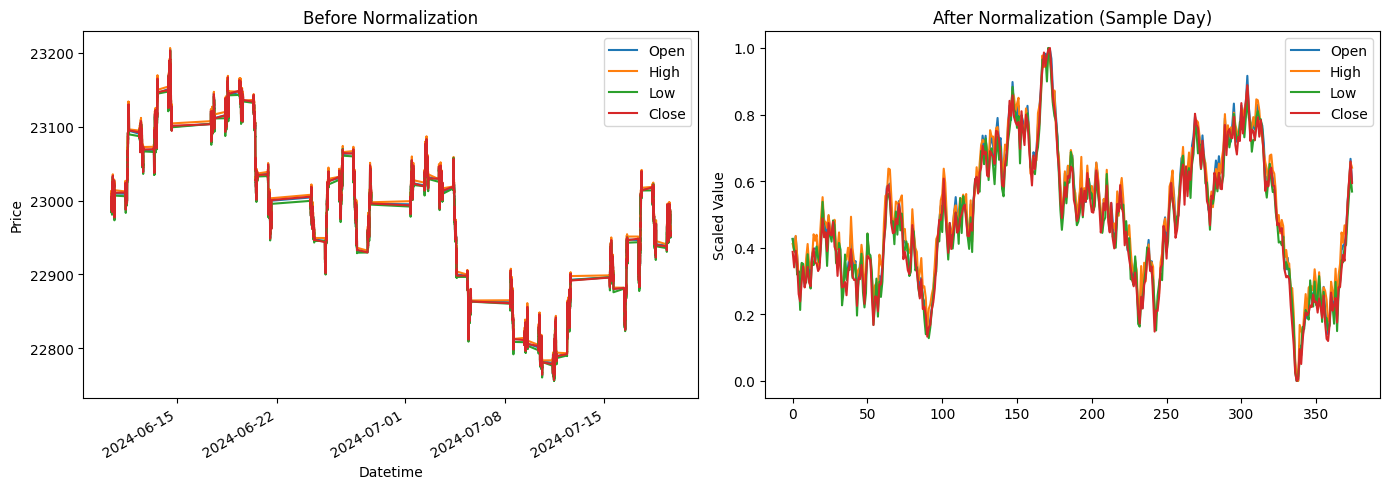

In [10]:
# Before normalization (original)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

df[['Open', 'High', 'Low', 'Close']].plot(ax=ax[0], title="Before Normalization")
ax[0].set_ylabel("Price")

# After normalization (one day)
sample_day = normalized_df_all[normalized_df_all['Date'] == normalized_df_all['Date'].unique()[0]]
sample_day[['Open', 'High', 'Low', 'Close']].plot(ax=ax[1], title="After Normalization (Sample Day)")
ax[1].set_ylabel("Scaled Value")

plt.tight_layout()
plt.show()


In [11]:
# First, get last closing price of each day
daily_close = df.groupby('Date')['Close'].last()

# Create trend labels (1 = Up, 0 = Down)
trend_labels = (daily_close.shift(-1) > daily_close).astype(int)
trend_labels.name = "Trend"

# Merge into normalized_df_all
normalized_df_all['Trend'] = normalized_df_all['Date'].map(trend_labels)

# Drop rows without a label (i.e., last day)
normalized_df_all = normalized_df_all.dropna(subset=['Trend'])
normalized_df_all['Trend'] = normalized_df_all['Trend'].astype(int)

# Optional: Drop the old 'Label' column to avoid confusion
normalized_df_all.drop(columns=['Label'], inplace=True, errors='ignore')

print("✅ Added 'Trend' column where 1 = Up, 0 = Down")
print(normalized_df_all[['Date', 'Close', 'Trend']].drop_duplicates().head())


✅ Added 'Trend' column where 1 = Up, 0 = Down
         Date     Close  Trend
0  2024-06-10  0.387643      1
1  2024-06-10  0.341041      1
2  2024-06-10  0.391350      1
3  2024-06-10  0.348985      1
4  2024-06-10  0.260900      1


In [12]:
df.head()

,Open,High,Low,Close,Volume,Date
Datetime,,,,,,
2024-06-10 09:15:00,22999.78,23000.24,22998.40,22998.93,9109,2024-06-10
2024-06-10 09:16:00,22997.94,22998.94,22996.33,22996.29,1269,2024-06-10
2024-06-10 09:17:00,23000.23,23001.69,22995.90,22999.14,1930,2024-06-10
2024-06-10 09:18:00,22996.84,22998.17,22992.08,22996.74,7205,2024-06-10
2024-06-10 09:19:00,22992.82,22994.13,22992.68,22991.75,6075,2024-06-10


In [13]:
normalized_df_all.to_csv("normalized_nifty_with_trend.csv", index=False)
print("✅ Saved as 'normalized_nifty_with_trend.csv'")


✅ Saved as 'normalized_nifty_with_trend.csv'


In [14]:
import pywt
import numpy as np

# Features to transform
features = ['Open', 'High', 'Low', 'Close', 'Volume']
all_days = normalized_df_all['Date'].unique()

X = []
y = []

# Loop through each day
for date in all_days:
    day_data = normalized_df_all[normalized_df_all['Date'] == date]
    
    if len(day_data) < 50:  # Skip incomplete days
        continue

    # Apply Haar DWT for each feature
    transformed = []
    for col in features:
        coeffs = pywt.dwt(day_data[col].values, 'haar')
        approx_coeffs = coeffs[0]  # Keep approximation only
        transformed.append(approx_coeffs)

    # Stack into 2D array: shape = (features, timesteps)
    X.append(np.stack(transformed, axis=0))
    y.append(day_data['Trend'].iloc[0])  # Use label for that day

X = np.array(X)
y = np.array(y).astype(int)

print("✅ Haar transform complete!")
print("X shape:", X.shape)  # Expecting: (samples, 5, N)
print("y shape:", y.shape)


✅ Haar transform complete!
X shape: (30, 5, 188)
y shape: (30,)


In [15]:
np.save("X_haar.npy", X)
np.save("y_trend.npy", y)

print("✅ Saved X_haar.npy and y_trend.npy")


✅ Saved X_haar.npy and y_trend.npy


📊 Class Distribution:
Label 1: 14 samples
Label 0: 16 samples


c:\Users\devar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


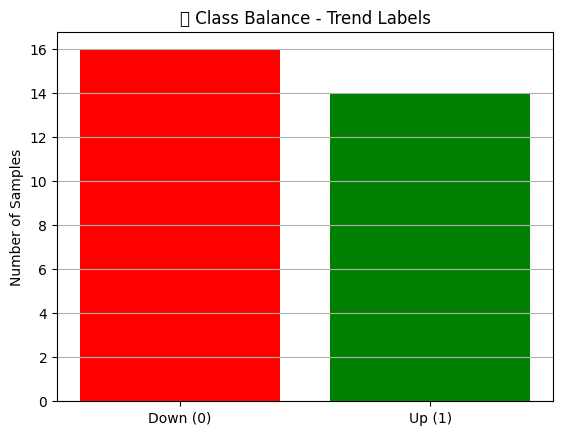

In [16]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Load labels
y = np.load("y_trend.npy")

# Count class distribution
counter = Counter(y)
print("📊 Class Distribution:")
for label, count in counter.items():
    print(f"Label {label}: {count} samples")

# Plot
plt.bar(counter.keys(), counter.values(), color=['green', 'red'])
plt.xticks([0, 1], ['Down (0)', 'Up (1)'])
plt.ylabel("Number of Samples")
plt.title("📉 Class Balance - Trend Labels")
plt.grid(True, axis='y')
plt.show()


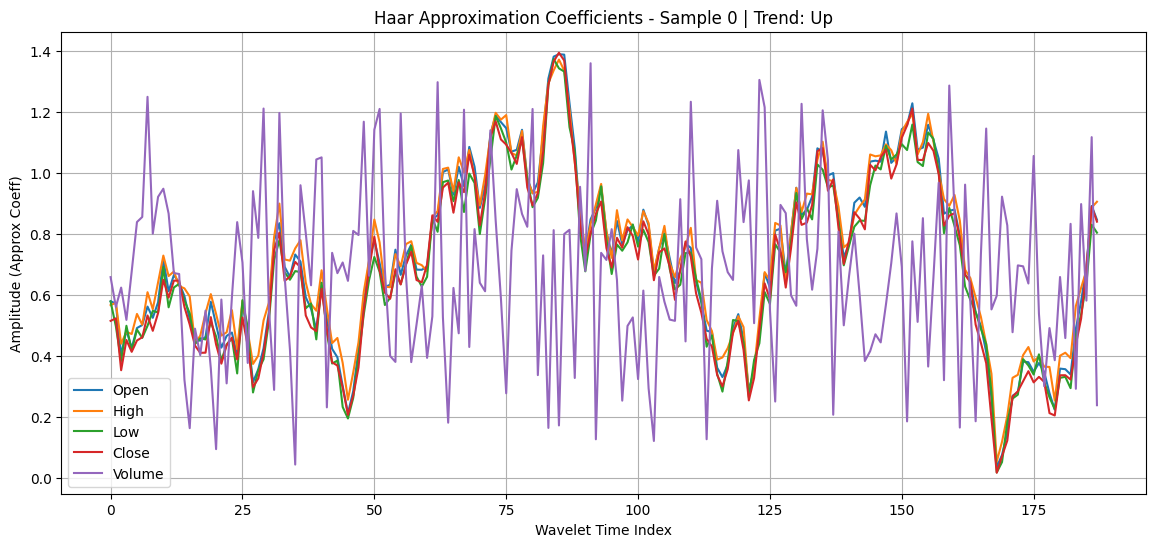

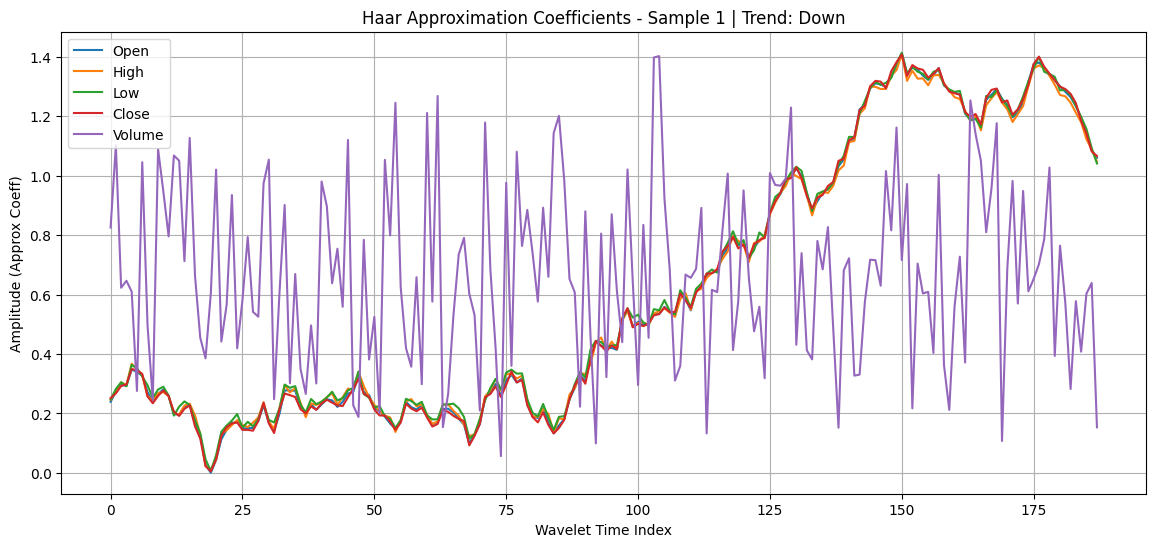

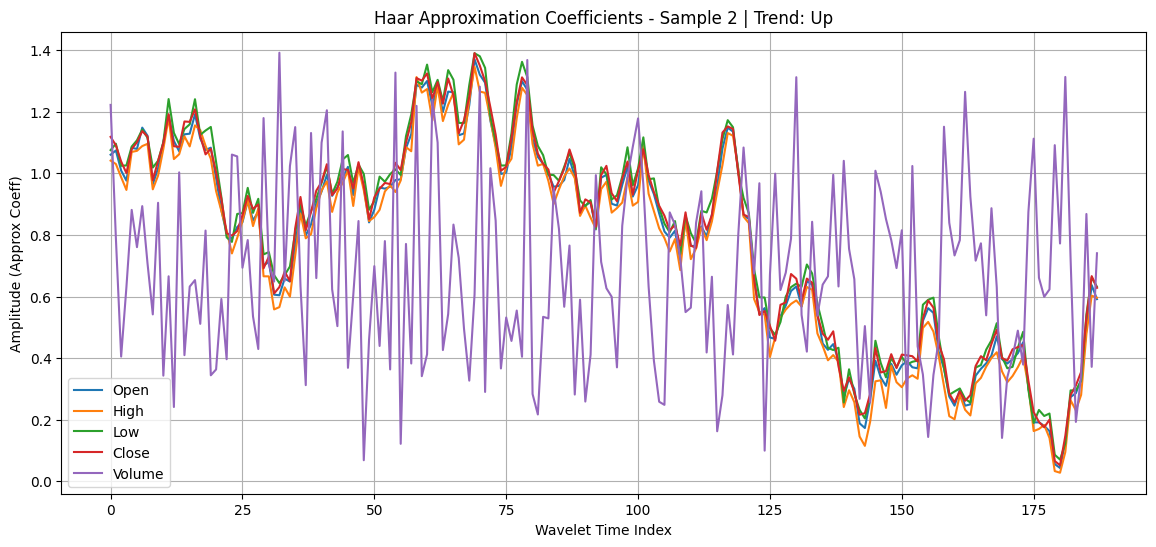

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Load Haar-transformed data
X = np.load("X_haar.npy")
y = np.load("y_trend.npy")

# Feature labels
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Visualize 3 samples (one per class if possible)
samples_to_plot = [0, 1, 2]  # You can randomize or pick specific ones

for idx in samples_to_plot:
    plt.figure(figsize=(14, 6))
    for i in range(5):  # 5 features
        plt.plot(X[idx, i], label=features[i])
    
    plt.title(f"Haar Approximation Coefficients - Sample {idx} | Trend: {'Up' if y[idx]==1 else 'Down'}")
    plt.xlabel("Wavelet Time Index")
    plt.ylabel("Amplitude (Approx Coeff)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [18]:
import numpy as np
import pywt
from scipy.stats import entropy

features = ['Open', 'High', 'Low', 'Close', 'Volume']
all_days = normalized_df_all['Date'].unique()

X_features = []
y_labels = []

def calc_energy(coeffs):
    return np.sum(np.square(coeffs))

def calc_entropy(coeffs):
    prob = np.square(coeffs)
    prob = prob / np.sum(prob)
    return entropy(prob)

for date in all_days:
    day_df = normalized_df_all[normalized_df_all['Date'] == date]
    if len(day_df) < 50: continue  # Skip incomplete days
    
    daily_features = []

    for col in features:
        data = day_df[col].values

        # Apply Haar DWT
        cA, cD = pywt.dwt(data, 'haar')

        # Extract features from Approximation Coefficients
        daily_features.append(np.mean(cA))        # Mean
        daily_features.append(np.std(cA))         # Std Dev
        daily_features.append(np.max(cA))         # Max
        daily_features.append(np.min(cA))         # Min
        daily_features.append(calc_energy(cA))    # Energy
        daily_features.append(calc_entropy(cA))   # Entropy

    X_features.append(daily_features)
    y_labels.append(day_df['Trend'].iloc[0])

X_features = np.array(X_features)
y_labels = np.array(y_labels)

print("✅ Extracted features shape:", X_features.shape)


✅ Extracted features shape: (30, 30)


In [19]:
np.save("X_wavelet_features.npy", X_features)
np.save("y_trend.npy", y_labels)

print("✅ Saved wavelet features to X_wavelet_features.npy")


✅ Saved wavelet features to X_wavelet_features.npy


In [20]:
import numpy as np

# Load features and labels
X = np.load("X_wavelet_features.npy")
y = np.load("y_trend.npy")

print("✅ Features shape:", X.shape)
print("✅ Labels shape:", y.shape)


✅ Features shape: (30, 30)
✅ Labels shape: (30,)


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("📊 Random Forest Report:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


📊 Random Forest Report:
[[4 1]
 [1 2]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.67      0.67      0.67         3

    accuracy                           0.75         8
   macro avg       0.73      0.73      0.73         8
weighted avg       0.75      0.75      0.75         8



In [23]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("📊 XGBoost Report:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


📊 XGBoost Report:
[[4 1]
 [1 2]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.67      0.67      0.67         3

    accuracy                           0.75         8
   macro avg       0.73      0.73      0.73         8
weighted avg       0.75      0.75      0.75         8



c:\Users\devar\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [09:46:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [24]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1.0)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("📊 SVM Report:")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


📊 SVM Report:
[[3 2]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.60      1.00      0.75         3

    accuracy                           0.75         8
   macro avg       0.80      0.80      0.75         8
weighted avg       0.85      0.75      0.75         8



In [25]:
from sklearn.metrics import accuracy_score

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")


Random Forest Accuracy: 0.75
XGBoost Accuracy: 0.75
SVM Accuracy: 0.75


In [26]:
import pandas as pd
import numpy as np

# Load extracted data
X = np.load("X_wavelet_features.npy")
y = np.load("y_trend.npy")

# Feature column names: 6 features per original signal (mean, std, max, min, energy, entropy)
base_signals = ['Open', 'High', 'Low', 'Close', 'Volume']
stat_names = ['mean', 'std', 'max', 'min', 'energy', 'entropy']

columns = [f"{signal}_{stat}" for signal in base_signals for stat in stat_names]

# Create DataFrame
df_features = pd.DataFrame(X, columns=columns)

# Add label column
df_features['Label'] = y

# Show preview
print(df_features.head())


   Open_mean  Open_std  Open_max  Open_min  Open_energy  Open_entropy  \
0   0.713841  0.280077  1.389548  0.036316   110.546213      4.984244   
1   0.613262  0.450554  1.411844  0.000346   108.868763      4.574651   
2   0.779346  0.328371  1.369828  0.043467   134.459113      4.974279   
3   0.617848  0.307232  1.395469  0.032790    89.511941      4.860618   
4   0.765423  0.361552  1.374338  0.003726   134.719434      4.940632   

   High_mean  High_std  High_max  High_min  ...  Close_min  Close_energy  \
0   0.733512  0.265250  1.371886  0.053850  ...   0.017475    102.681179   
1   0.613780  0.442888  1.408051  0.011937  ...   0.004670    109.431645   
2   0.753973  0.334033  1.345784  0.028098  ...   0.052257    139.937093   
3   0.604417  0.308408  1.378202  0.014437  ...   0.022990     89.264418   
4   0.775977  0.359047  1.371192  0.013586  ...   0.027694    140.410731   

   Close_entropy  Volume_mean  Volume_std  Volume_max  Volume_min  \
0       4.964781     0.671575    0.

In [27]:
df_features.to_csv("wavelet_features_with_labels.csv", index=False)
print("✅ Saved to 'wavelet_features_with_labels.csv'")


✅ Saved to 'wavelet_features_with_labels.csv'


In [28]:
df.head()
normalized_df_all.head()

,Datetime,Open,High,Low,Close,Volume,Date,Trend
0,2024-06-10 09:15:00,0.426117,0.411540,0.426775,0.387643,0.902149,2024-06-10,1
1,2024-06-10 09:16:00,0.393865,0.389924,0.391607,0.341041,0.029389,2024-06-10,1
2,2024-06-10 09:17:00,0.434005,0.435650,0.384302,0.391350,0.102972,2024-06-10,1
3,2024-06-10 09:18:00,0.374584,0.377120,0.319402,0.348985,0.690193,2024-06-10,1
4,2024-06-10 09:19:00,0.304119,0.309943,0.329596,0.260900,0.564399,2024-06-10,1


In [29]:
df.head()

,Open,High,Low,Close,Volume,Date
Datetime,,,,,,
2024-06-10 09:15:00,22999.78,23000.24,22998.40,22998.93,9109,2024-06-10
2024-06-10 09:16:00,22997.94,22998.94,22996.33,22996.29,1269,2024-06-10
2024-06-10 09:17:00,23000.23,23001.69,22995.90,22999.14,1930,2024-06-10
2024-06-10 09:18:00,22996.84,22998.17,22992.08,22996.74,7205,2024-06-10
2024-06-10 09:19:00,22992.82,22994.13,22992.68,22991.75,6075,2024-06-10


In [30]:
df['Trend'] = normalized_df_all['Trend']

In [31]:
df.head()

,Open,High,Low,Close,Volume,Date,Trend
Datetime,,,,,,,
2024-06-10 09:15:00,22999.78,23000.24,22998.40,22998.93,9109,2024-06-10,NaN
2024-06-10 09:16:00,22997.94,22998.94,22996.33,22996.29,1269,2024-06-10,NaN
2024-06-10 09:17:00,23000.23,23001.69,22995.90,22999.14,1930,2024-06-10,NaN
2024-06-10 09:18:00,22996.84,22998.17,22992.08,22996.74,7205,2024-06-10,NaN
2024-06-10 09:19:00,22992.82,22994.13,22992.68,22991.75,6075,2024-06-10,NaN


In [32]:
normalized_df_all.head()

,Datetime,Open,High,Low,Close,Volume,Date,Trend
0,2024-06-10 09:15:00,0.426117,0.411540,0.426775,0.387643,0.902149,2024-06-10,1
1,2024-06-10 09:16:00,0.393865,0.389924,0.391607,0.341041,0.029389,2024-06-10,1
2,2024-06-10 09:17:00,0.434005,0.435650,0.384302,0.391350,0.102972,2024-06-10,1
3,2024-06-10 09:18:00,0.374584,0.377120,0.319402,0.348985,0.690193,2024-06-10,1
4,2024-06-10 09:19:00,0.304119,0.309943,0.329596,0.260900,0.564399,2024-06-10,1


In [33]:
normalized_df_all['Trend'].value_counts()

Trend
0    6000
1    5250
Name: count, dtype: int64

In [34]:
normalized_df_all.to_csv("normalized_nifty_with_trend.csv", index=False)

In [36]:
!pip install -U scikit-learn imbalanced-learn


  Using cached scikit_learn-1.7.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.11.0
    Uninstalling imbalanced-learn-0.11.0:
      Successfully uninstalled imbalanced-learn-0.11.0


In [37]:
import sklearn
import imblearn
print("scikit-learn version:", sklearn.__version__)
print("imbalanced-learn version:", imblearn.__version__)


scikit-learn version: 1.6.1
imbalanced-learn version: 0.13.0


=== SVM Classification Report ===
              precision    recall  f1-score   support

           0       0.54      0.53      0.54      1200
           1       0.54      0.55      0.54      1200

    accuracy                           0.54      2400
   macro avg       0.54      0.54      0.54      2400
weighted avg       0.54      0.54      0.54      2400

Confusion Matrix (SVM):
[[636 564]
 [540 660]]

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.64      0.63      0.64      1200
           1       0.64      0.65      0.64      1200

    accuracy                           0.64      2400
   macro avg       0.64      0.64      0.64      2400
weighted avg       0.64      0.64      0.64      2400

Confusion Matrix (XGBoost):
[[753 447]
 [418 782]]


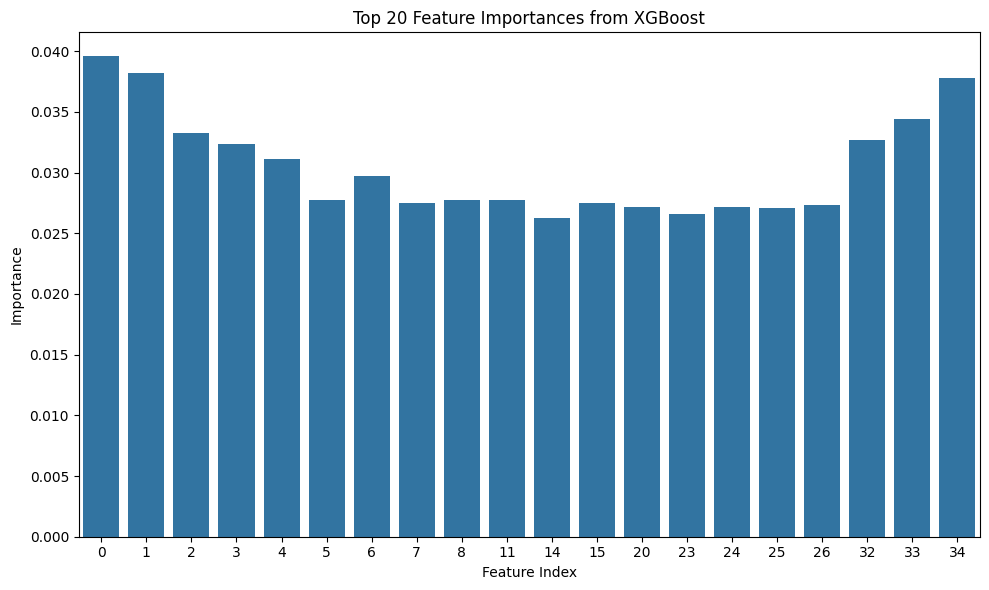

In [38]:
import pandas as pd
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("normalized_nifty_labeled.csv")

# Function to extract Haar features using rolling window
def haar_features(data, level=4, window=32):
    result = []
    for i in range(len(data) - window):
        window_data = data[i:i+window]
        coeffs = pywt.wavedec(window_data, 'haar', level=level)
        result.append(np.concatenate(coeffs))
    return np.array(result)

# Apply Haar transform to 'Close'
window_size = 32
close_prices = df['Close'].values
X_haar = haar_features(close_prices, level=4, window=window_size)
y = df['Label'].values[window_size:]

# Add normalized features
additional_features = df[['Open', 'High', 'Low', 'Volume']].values[window_size:]
X_combined = np.hstack([X_haar, additional_features])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Balance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# SVM Model
svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# XGBoost Model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluation
print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix (SVM):")
print(confusion_matrix(y_test, y_pred_svm))

print("\n=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))

# Feature importance from XGBoost
importances = xgb.feature_importances_
top_indices = np.argsort(importances)[-20:]
plt.figure(figsize=(10, 6))
sns.barplot(x=top_indices, y=importances[top_indices])
plt.title("Top 20 Feature Importances from XGBoost")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}

# Initialize base model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best estimator
best_xgb = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_xgb.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print("\n=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 144 candidates, totalling 432 fits


c:\Users\devar\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [10:00:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1200
           1       0.64      0.66      0.65      1200

    accuracy                           0.65      2400
   macro avg       0.65      0.65      0.64      2400
weighted avg       0.65      0.65      0.64      2400


Confusion Matrix:
[[753 447]
 [405 795]]


In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("normalized_nifty_labeled.csv")

# Use 5 core features
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
labels = df['Label'].values

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences (rolling windows)
def create_sequences(X, y, window_size=32):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

window_size = 32
X_seq, y_seq = create_sequences(features_scaled, labels, window_size)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(window_size, X_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # 2 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print("\n=== LSTM Classification Report ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



c:\Users\devar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,066 (78.38 KB)

 Trainable params: 20,066 (78.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5313 - loss: 0.6932 - val_accuracy: 0.4844 - val_loss: 0.6943
Epoch 2/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5221 - loss: 0.6898 - val_accuracy: 0.4944 - val_loss: 0.6944
Epoch 3/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5418 - loss: 0.6849 - val_accuracy: 0.5290 - val_loss: 0.6899
Epoch 4/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5367 - loss: 0.6874 - val_accuracy: 0.4900 - val_loss: 0.6888
Epoch 5/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5402 - loss: 0.6845 - val_accuracy: 0.5245 - val_loss: 0.6934
Epoch 6/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5681 - loss: 0.6760 - val_accuracy: 0.6102 - val_loss: 0.6696
Epoch 7/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5746 - loss: 0.6687 - val_accuracy: 0.5891 - val_loss: 0.6716
Epoch 8/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5845 - loss: 0.6634 - val_accu

In [43]:
# Save the model to an HDF5 file
model.save("nifty_lstm_model.h5")


In [44]:
from tensorflow.keras.models import load_model
model = load_model("nifty_lstm_model.h5")


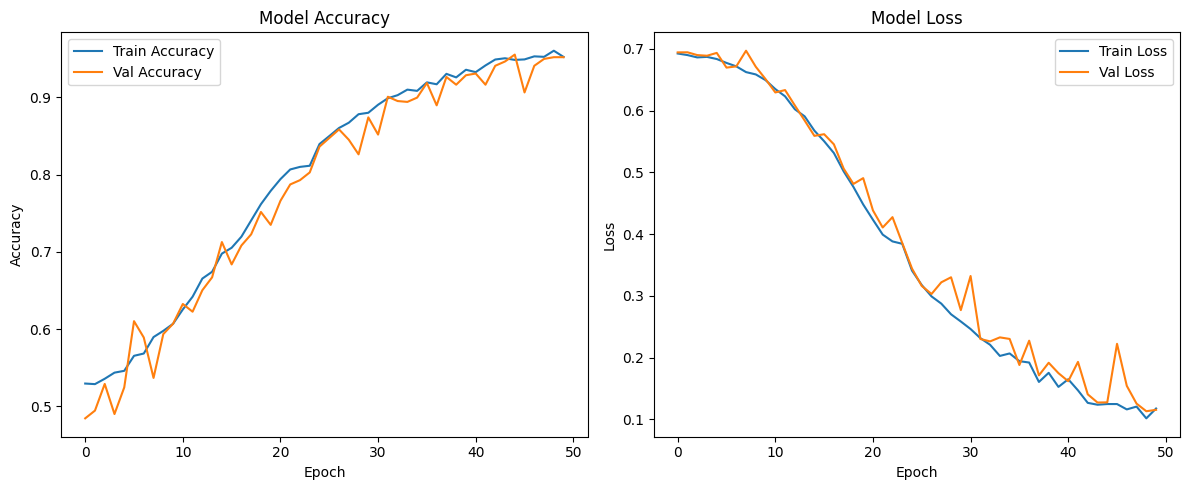

In [46]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
